# Interpretability of autoencoder latent space for passengers demand-sensitive planning on high-speed railways (IWANN 2023)


In [1]:
import datetime
import nltk
import numpy as np
import os
import pandas as pd
import random
import tensorflow as tf

from feature_engine.creation import CyclicalFeatures
from nltk.corpus import wordnet
from scipy import spatial
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from typing import Dict, List, Tuple

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

EMBEDDING_DIM = 50

In [2]:
# Download wordnet if not already downloaded
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/david/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
from src.robin.supply.entities import Supply

def get_paths_from_supply(path_config_supply: str = '../configs/test_case/supply_data.yml') -> List[List[str]]:
    """
    Get the paths of a supply

    Args:
        path_config_supply (str, optional): Path to the supply config file. Defaults to '../configs/test_case/supply_data.yml'.

    Returns:
        List[List[str]]: List of paths
    """
    supply = Supply.from_yaml(path_config_supply)

    # Get set of corridors
    corridors = []
    for service in supply.services:
        if service.line.corridor not in corridors:
            corridors.append(service.line.corridor)

    # Get set of paths
    paths = []
    for corridor in corridors:
        for path in corridor.paths:
            if path not in paths:
                paths.append(path)

    # Parse paths of Station objects to paths of station mame
    paths = [[station.name.replace("-", " ").split(" ")[0].lower() for station in path] for path in paths]
    return paths

paths = get_paths_from_supply()
print(paths)

[['madrid', 'guadalajara', 'calatayud', 'zaragoza', 'lleida', 'tarragona', 'barcelona', 'girona', 'figueres']]


In [10]:
def get_random_pair(paths: list[list]) -> Tuple[str, str]:
    """
    Get a random pair of stations from a path

    Args:
        paths (list[list]): List of stations

    Returns:
        Tuple[str, str]: Tuple with the origin and destination stations
    """
    random_path = random.choice(paths)  # Choose a random path

    origin_index = random.randint(0, len(random_path) - 2)  # Choose a random origin station
    destination_index = random.randint(origin_index + 1, len(random_path) - 1)  # Choose a random destination station

    origin_station = random_path[origin_index]
    destination_station = random_path[destination_index]
    return origin_station, destination_station

In [11]:
def get_renfe_station_id(adif_id: str, stations_df: pd.DataFrame) -> str:
    """
    Returns the Station name given the Adif station id.

    Args:
        adif_id (str): Adif station id.
        stations_df (pd.DataFrame): Dataframe with the stations' information.

    Returns:
        str: Station name.
    """
    station_name = stations_df[stations_df['stop_id'] == adif_id]['stop_name'].values[0]
    station_name = station_name.replace("-", " ").split(" ")[0].lower()
    return station_name

stations_csv_path = f'../data/renfe/renfe_stations.csv'
stations_df = pd.read_csv(stations_csv_path, dtype={'stop_id': str, 'renfe_id': str})

In [12]:
def simulate_passengers_data(paths: list,
                             user_patterns: list,
                             n_passengers: int = 10000,
                             seed: int = 42
    ) -> pd.DataFrame:
    # Set random state
    random.seed(seed)

    pairs = []
    for _ in range(n_passengers):
        pairs.append(get_random_pair(paths))

    df = pd.DataFrame(pairs, columns=['origin', 'destination'])
    df['user_pattern'] = [random.choice(user_patterns) for _ in range(n_passengers)]

    random_days = lambda: random.randint(0, 365*10)
    random_hours = lambda: random.randint(0, 24)
    random_minutes = lambda: random.randint(0,60)

    random_timedelta = lambda: datetime.timedelta(days=random_days(), hours=random_hours(), minutes=random_minutes())
    df['arrival_date'] = [datetime.datetime(2021, 1, 1) + random_timedelta() for _ in range(n_passengers)]
    df['week_day'] = [date.strftime('%A').lower() for date in df['arrival_date']]
    df['month'] = [date.strftime('%B').lower() for date in df['arrival_date']]
    df['time'] = [date.time() for date in df['arrival_date']]
    return df

user_patterns = ("business", "student", "tourist")
df = simulate_passengers_data(paths, user_patterns, n_passengers=10000)
print(df.head())

        origin  destination user_pattern        arrival_date   week_day  \
0       madrid    tarragona      tourist 2027-05-03 14:39:00     monday   
1     zaragoza    tarragona     business 2028-01-04 23:52:00    tuesday   
2  guadalajara    barcelona     business 2027-08-13 01:46:00     friday   
3       madrid  guadalajara      student 2028-08-30 07:48:00  wednesday   
4     zaragoza    tarragona      student 2029-08-27 04:15:00     monday   

     month      time  
0      may  14:39:00  
1  january  23:52:00  
2   august  01:46:00  
3   august  07:48:00  
4   august  04:15:00  


In [13]:
class AutoencoderEmbedding:
    """
    Class to get the embedding of a dataframe to be used as input of an autoencoder

    Attributes:
        df (pd.DataFrame): Dataframe with the data to be embedded
        df_embedding (pd.DataFrame): Dataframe with the embedding.
        embedding_dim (int, optional): Embedding dimension. Defaults to 50.
        embedding_dict (dict): Dictionary with the embedding.
        scaler (MinMaxScaler): Scaler to normalize the data.
        cyclical (CyclicalFeatures): Cyclical features transformer.
        df_time (pd.DataFrame): Dataframe with the time embedding.
        input_arrays (list[np.array]): List of arrays with the embedded input data.
    """
    def __init__(self, df: pd.DataFrame, embedding_dim: int = 50, noise: bool = True):
        """
        Constructor method

        Args:
            df (pd.DataFrame): Dataframe with the data to be embedded
            embedding_dim (int, optional): Embedding dimension. Defaults to 50.
        """
        self.df = df
        self.noise = noise
        self.embedding_dim = embedding_dim
        self.scaler = MinMaxScaler()
        self.cyclical = CyclicalFeatures(variables=['time'], drop_original=True)
        if self.noise:
            self.df_noisy = self._get_noisy_df()

        df_bag_words = pd.concat([self.df_noisy, self.df], ignore_index=True) if self.noise else self.df
        words_set = set(df_bag_words[['origin', 'destination', 'user_pattern', 'week_day', 'month']].values.flatten())
        self.word_index = {word: index for index, word in enumerate(words_set)}
        self.embedding_dict = self._get_embedding_dict()

        if self.noise:
            self.df_embedding_noisy = self._get_embedding_df(self.df_noisy)
            #for x in self.df_embedding_noisy['origin'].values.tolist():
            #    print(x)
            #    print(len(x))
            self.words_noisy_embedding = self._get_words_embedding(self.df_embedding_noisy)
            self.time_noisy_embedding = self._get_time_embedding(self.df_embedding_noisy)
        self.df_embedding = self._get_embedding_df(self.df)
        self.words_embeddings = self._get_words_embedding(self.df_embedding)
        self.time_embedding = self._get_time_embedding(self.df_embedding)

    def _get_words_embedding(self, df: pd.DataFrame) -> np.array:
        """
        Get the words embedding.

        Args:
            df (pd.DataFrame, optional): Dataframe with the data to be embedded. Defaults to None.

        Returns:
            np.array: Array with the words embedding.
        """
        input_data = df[['origin', 'destination', 'user_pattern', 'week_day', 'month']].values.tolist()
        return np.array([np.asarray(row, dtype=np.float32) for row in input_data])

    def _get_time_embedding(self, df: pd.DataFrame) -> np.array:
        """
        Get the time embedding.

        Args:
            df (pd.DataFrame, optional): Dataframe with the data to be embedded.

        Returns:
            np.array: Array with the time embedding.
        """
        input_data = df[['time']].values.tolist()
        return np.array([np.asarray(row, dtype=np.float32) for row in input_data])

    def _get_embedding_dict(self) -> Dict[str, np.array]:
        """
        Get the words embedding dictionary

        Returns:
            Dict[str, np.array]: Dictionary with the embedding.
        """
        embeddings_index = {}
        f = open(os.path.join('../data/pretrained/glove6B/glove.6B.50d.txt'))

        # Read GloVe embeddings
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype=np.float32)
            embeddings_index[word] = coefs
        f.close()

        # Create embedding matrix
        embedding_matrix = np.zeros((len(self.word_index) + 1, self.embedding_dim))
        embedding_dict = {}
        for word, i in self.word_index.items():
            embedding_vector = embeddings_index.get(word, np.zeros(self.embedding_dim))
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                embedding_dict[word] = embedding_vector

        return embedding_dict

    def decode_time_embedding(self, time_embedding: np.array) -> datetime.time:
        """
        Decode the time embedding

        Args:
            time_embedding (np.array): Time embedding

        Returns:
            datetime.time: Time
        """
        total_minutes = self.scaler.inverse_transform(time_embedding)
        hours = int(total_minutes / 60)
        minutes = int(total_minutes % 60)
        time = datetime.time(hour=hours, minute=minutes)

        return time

    def get_word_syn(self, word: str) -> str:
        """
        Get a random synonym of a word

        Args:
            word (str): Word to get the synonym from

        Returns:
            str: Synonym of the word
        """
        word_synset = wordnet.synsets(word)
        if len(word_synset) > 0:
            station_synset = word_synset[0]
            station_lemmas = station_synset.lemmas()
            if len(station_lemmas) > 0:
                word_lemma = random.choice(station_lemmas)
                return word_lemma.name().lower()

        return word

    def _get_noisy_df(self, p: float = 0.2) -> pd.DataFrame:
        """
        Get the noisy embedding dataframe by replacing some of the words with synonyms

        Returns:
            pd.DataFrame: Noisy embedding dataframe.
        """
        df_noisy = self.df.copy()
        df_noisy['origin'] = df_noisy['origin'].apply(lambda x: self.get_word_syn(x) if random.random() < p else x)
        df_noisy['destination'] = df_noisy['destination'].apply(lambda x: self.get_word_syn(x) if random.random() < p else x)
        df_noisy['user_pattern'] = df_noisy['user_pattern'].apply(lambda x: self.get_word_syn(x) if random.random() < p else x)
        df_noisy['week_day'] = df_noisy['week_day'].apply(lambda x: self.get_word_syn(x) if random.random() < p else x)
        df_noisy['month'] = df_noisy['month'].apply(lambda x: self.get_word_syn(x) if random.random() < p else x)

        # Replace time with a similar date (sum random timedelta of minutes in range [-30, 30])
        df_noisy['time'] = df_noisy['arrival_date'].apply(lambda x: x + datetime.timedelta(minutes=random.randint(-30, 30)) if random.random() < p else x)
        df_noisy['time'] = df_noisy['time'].apply(lambda x: x.time())

        return df_noisy

    def _get_embedding_df(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Get embedding dataframe.

        Returns:
            pd.DataFrame: Embedding dataframe.
        """
        df_embedding = df.copy()
        df_embedding['origin'] = df_embedding['origin'].apply(lambda x: self.embedding_dict.get(x))
        df_embedding['destination'] = df_embedding['destination'].apply(lambda x: self.embedding_dict.get(x))
        df_embedding['user_pattern'] = df_embedding['user_pattern'].apply(lambda x: self.embedding_dict.get(x))
        df_embedding['week_day'] = df_embedding['week_day'].apply(lambda x: self.embedding_dict.get(x))
        df_embedding['month'] = df_embedding['month'].apply(lambda x: self.embedding_dict.get(x))

        def total_minutes(time: datetime.datetime) -> np.float32:
            total_minutes = (time.hour * 60) + time.minute
            return np.float32(total_minutes)
        df_embedding['time'] = df_embedding['time'].apply(lambda x: total_minutes(x))
        df_embedding['time'] = self.scaler.fit_transform(df_embedding[['time']])

        return df_embedding[['origin', 'destination', 'user_pattern', 'week_day', 'month', 'time']]

In [15]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

print("Train data shape: ", df_train.shape)
print("Test data shape: ", df_test.shape)

train_embedding = AutoencoderEmbedding(df = df_train, embedding_dim=EMBEDDING_DIM)
test_embedding = AutoencoderEmbedding(df = df_test, embedding_dim=EMBEDDING_DIM, noise=False)

print("Test data autoencoder input shape: ", test_embedding.words_embeddings.shape)
print("First test data instance: ", test_embedding.df.iloc[0])
print("First test data instance embedded: ", test_embedding.words_embeddings[0])
print(test_embedding.df_embedding.head())

Train data shape:  (7000, 7)
Test data shape:  (3000, 7)
Test data autoencoder input shape:  (3000, 5, 50)
First test data instance:  origin                     zaragoza
destination                  lleida
user_pattern                student
arrival_date    2027-06-13 22:10:00
week_day                     sunday
month                          june
time                       22:10:00
Name: 6252, dtype: object
First test data instance embedded:  [[ 1.0642    0.089939 -0.28715   0.82471   0.31063  -1.4798    0.12028
   0.7449   -1.2919    0.39737   0.4715   -0.53483  -0.48049  -1.2998
   0.32826  -1.3085   -0.67916  -0.20625  -0.7232    0.41638  -1.2895
  -0.69963  -0.23631   0.70175  -0.61498   0.20193   1.329     0.25294
  -0.093715 -0.16535   0.99605   1.2007   -0.26729  -0.42035  -0.15881
   0.63906  -0.73977   1.3119    0.61136  -0.59197   1.3032    0.16094
  -0.027686 -0.9412   -0.68288   0.65116   0.47976  -0.32516   1.3912
  -0.50467 ]
 [ 0.23779  -0.70155  -1.123     0.36108  -1.

## Embedding Model

## Autoencoder model

In [16]:
words_embeddings_shape = (5, EMBEDDING_DIM)
time_embedding_shape = (1,)

SEQUENCE_LENGTH = 5

latent_dim = 5

# Encoder model
input_words = Input(shape=words_embeddings_shape)

conv1 = Conv1D(64, kernel_size=3, activation='relu', padding='same')(input_words)
conv2 = Conv1D(32, kernel_size=3, activation='relu', padding='same')(conv1)
pooling = GlobalMaxPooling1D()(conv2)
flat_layer = Flatten()(pooling)

input_time = Input(shape=time_embedding_shape)
concat_layer = Concatenate(axis=1)([flat_layer, input_time])

encoder = Dense(64)(concat_layer)
encoder = Dense(32)(encoder)

dense1 = Dense(latent_dim)(encoder)

# Decoder model
decoder_inputs = Input(shape=(latent_dim,))
dense3 = Dense(32)(decoder_inputs)
dense4 = Dense(64)(dense3)

repeat_vector = RepeatVector(6)(Flatten()(dense4))

decoder = Dense(32 * SEQUENCE_LENGTH, activation='relu')(dense4)
decoder = Reshape((SEQUENCE_LENGTH, 32))(decoder)
decoder = Conv1DTranspose(32, kernel_size=3, activation='relu', padding='same')(decoder)
decoder = Conv1DTranspose(64, kernel_size=3, activation='relu', padding='same')(decoder)
decoder_words = Conv1DTranspose(EMBEDDING_DIM, kernel_size=3, padding='same')(decoder)

decoder_time = Dense(1)(dense4)

encoder_model = Model(inputs=[input_words, input_time], outputs=dense1)
decoder_model = Model(inputs=decoder_inputs, outputs=[decoder_words, decoder_time])

decoded_words, decoded_time = decoder_model(dense1)
model = Model(inputs=[input_words, input_time], outputs=[decoded_words, decoded_time])

model.compile(optimizer='rmsprop', loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])
model.summary()

2023-05-23 13:09:23.161275: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 13:09:27.342296: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 50)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 5, 64)        9664        ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 5, 32)        6176        ['conv1d[0][0]']                 
                                                                                                  
 global_max_pooling1d (GlobalMa  (None, 32)          0           ['conv1d_1[0][0]']               
 xPooling1D)                                                                                

In [17]:
history = model.fit(x = [train_embedding.words_embeddings, train_embedding.time_embedding],
                    y = [train_embedding.words_embeddings, train_embedding.time_embedding],
                    epochs=10,
                    batch_size=32,
                    verbose=1)

Epoch 1/10
219/219 [==============================] - 2s 3ms/step - loss: 0.1759 - model_1_loss: 0.1405 - model_1_1_loss: 0.0354 - model_1_mean_squared_error: 0.1405 - model_1_1_mean_squared_error: 0.0354
Epoch 2/10
219/219 [==============================] - 1s 2ms/step - loss: 0.0804 - model_1_loss: 0.0771 - model_1_1_loss: 0.0033 - model_1_mean_squared_error: 0.0771 - model_1_1_mean_squared_error: 0.0033
Epoch 3/10
219/219 [==============================] - 1s 3ms/step - loss: 0.0569 - model_1_loss: 0.0544 - model_1_1_loss: 0.0025 - model_1_mean_squared_error: 0.0544 - model_1_1_mean_squared_error: 0.0025
Epoch 4/10
219/219 [==============================] - 1s 3ms/step - loss: 0.0477 - model_1_loss: 0.0457 - model_1_1_loss: 0.0020 - model_1_mean_squared_error: 0.0457 - model_1_1_mean_squared_error: 0.0020
Epoch 5/10
219/219 [==============================] - 1s 2ms/step - loss: 0.0410 - model_1_loss: 0.0393 - model_1_1_loss: 0.0018 - model_1_mean_squared_error: 0.0393 - model_1_1_me

## Plot history

In [18]:
history.history.keys()

dict_keys(['loss', 'model_1_loss', 'model_1_1_loss', 'model_1_mean_squared_error', 'model_1_1_mean_squared_error'])

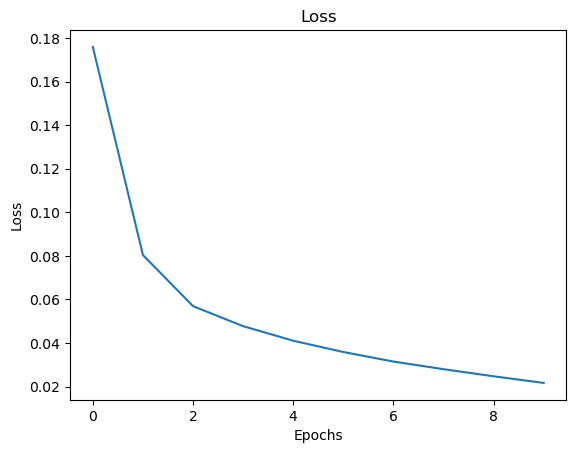

In [19]:
# Plot history loss and mse

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [20]:
# Evaluate model
score = model.evaluate(x=[test_embedding.words_embeddings, test_embedding.time_embedding],
                       y=[test_embedding.words_embeddings, test_embedding.time_embedding],
                       verbose=1)

94/94 [==============================] - 0s 2ms/step - loss: 0.0268 - model_1_loss: 0.0242 - model_1_1_loss: 0.0026 - model_1_mean_squared_error: 0.0242 - model_1_1_mean_squared_error: 0.0026


## Make predictions

In [21]:
def find_closest_embeddings(embedding, emb):
    return sorted(emb.keys(), key=lambda word: spatial.distance.euclidean(emb[word], embedding))[0]

In [22]:
random_index = np.random.randint(0, test_embedding.df.shape[0])

random_words_embedding = test_embedding.words_embeddings[random_index:random_index+1]
random_time_embedding = test_embedding.time_embedding[random_index:random_index+1]

print("Input - Random passenger data: ")
print(test_embedding.df.iloc[random_index])

prediction = model.predict(x = [random_words_embedding, random_time_embedding])

print("Output - Passenger reconstruction: ")
decoded_words = [find_closest_embeddings(word_vector, test_embedding.embedding_dict) for word_vector in prediction[0][0]]
print(decoded_words)

print("Time prediction: ")
predicted_time = test_embedding.decode_time_embedding([prediction[1][0]])
print(predicted_time)

Input - Random passenger data: 
origin                    calatayud
destination               tarragona
user_pattern               business
arrival_date    2025-11-28 17:52:00
week_day                     friday
month                      november
time                       17:52:00
Name: 8341, dtype: object
1/1 [==============================] - 0s 185ms/step
Output - Passenger reconstruction: 
['calatayud', 'tarragona', 'business', 'wednesday', 'december']
Time prediction: 
17:44:00


## Estudio de la correlación entre factores latentes y la entrada del autoencoder

In [46]:
# New df from test_embedding.df

df_test = test_embedding.df.copy()

# Set all values of row 'origin' to 'madrid'

df_test['origin'] = 'madrid'
#df_test['destination'] = 'madrid'
#df_test['user_pattern'] = 'business'
#df_test['week_day'] = 'monday'
#df_test['month'] = 'january'
#df_test['time'] = datetime.datetime(2020, 1, 1, 10, 18, 30)

fixed_embedding = AutoencoderEmbedding(df = df_test, embedding_dim=EMBEDDING_DIM)

# Get latent space from fixed_embedding
latent_space = encoder_model.predict(x = [fixed_embedding.words_embeddings, fixed_embedding.time_embedding])

# Get range of values for each latent factor
latent_space_range = pd.DataFrame(latent_space).describe().loc[['min', 'max']]

print("Latent space range: ")
print(latent_space_range)

94/94 [==============================] - 0s 1ms/step
Latent space range: 
            0         1         2         3         4
min -0.685368 -1.758703 -0.807945 -1.330426 -1.657424
max  0.856519 -0.125330  1.686299  1.119511  0.329995


   latent_0  latent_1  latent_2  latent_3  latent_4
0  0.246651 -1.217494  0.384339 -1.156676  0.302237
1  0.280755  0.547266  1.372185  0.390878  0.722794
2 -0.158233 -0.167382  0.019862  0.775883 -0.127805
3 -0.064373 -0.788396  0.202836 -0.497544  0.431263
4  0.458995 -0.673099  0.617731  0.842813 -0.205029


[]

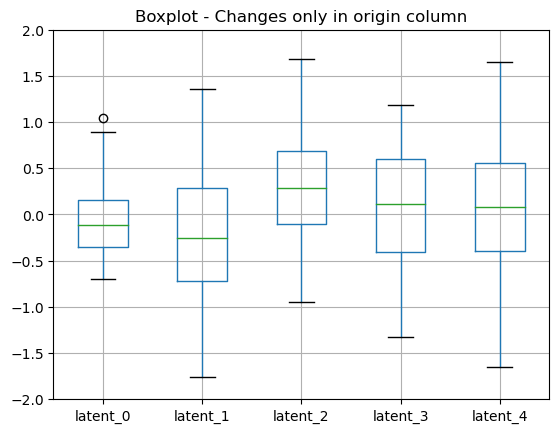

In [45]:
from matplotlib import pyplot as plt

# Cambios en origen
df_predictions = pd.DataFrame(latent_space, columns = [f"latent_{i}" for i in range(latent_dim)])
print(df_predictions.head())

b_plot = df_predictions.boxplot()
plt.ylim(-2.0, 2.0)

plt.title("Boxplot - Changes only in origin column")
b_plot.plot()

   latent_0  latent_1  latent_2  latent_3  latent_4
0  0.341337 -1.581254  0.492442 -1.214517 -0.155201
1  0.082326 -0.633223  1.536714  0.637654 -0.434126
2 -0.028026 -0.571460  0.240216  1.058021 -0.609698
3  0.031639 -1.466675  0.358423 -0.500821 -0.328038
4  0.458995 -0.673099  0.617731  0.842813 -0.205029


[]

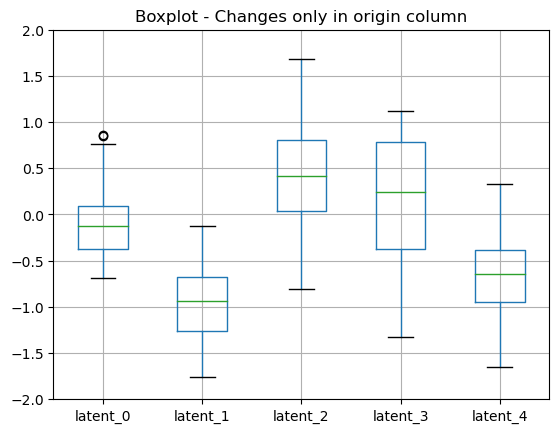

In [47]:
from matplotlib import pyplot as plt

# Cambios en origen
df_predictions = pd.DataFrame(latent_space, columns = [f"latent_{i}" for i in range(latent_dim)])
print(df_predictions.head())

b_plot = df_predictions.boxplot()
plt.ylim(-2.0, 2.0)

plt.title("Boxplot - Changes only in origin column")
b_plot.plot()

In [23]:
# Get latent space from every possible combination of fixed dfs
df_test = test_embedding.df.copy()

# Get set of values in 'origin' column
origin_values = set(df_test['origin'].values)
destination_values = set(df_test['destination'].values)
user_pattern_values = set(df_test['user_pattern'].values)
week_day_values = set(df_test['week_day'].values)
month_values = set(df_test['month'].values)
time_values = set(df_test['time'].values)

df_test = test_embedding.df.copy()
df_test['destination'] = 'barcelona'
df_test['user_pattern'] = 'business'
df_test['week_day'] = 'monday'
df_test['month'] = 'january'
df_test['time'] = datetime.datetime(year=2023, month=1, day=1, hour=18, minute=30)

fixed_data = AutoencoderEmbedding(df = df_test, embedding_dim=EMBEDDING_DIM)

latent_space = encoder_model.predict(x = [fixed_data.words_embeddings, fixed_data.time_embedding])

94/94 [==============================] - 0s 1ms/step


Shape of tsne_latent_space[df_test['origin'] == calatayud]: (388, 2)
Shape of tsne_latent_space[df_test['origin'] == lleida]: (389, 2)
Shape of tsne_latent_space[df_test['origin'] == girona]: (352, 2)
Shape of tsne_latent_space[df_test['origin'] == tarragona]: (364, 2)
Shape of tsne_latent_space[df_test['origin'] == zaragoza]: (381, 2)
Shape of tsne_latent_space[df_test['origin'] == guadalajara]: (367, 2)
Shape of tsne_latent_space[df_test['origin'] == madrid]: (369, 2)
Shape of tsne_latent_space[df_test['origin'] == barcelona]: (390, 2)


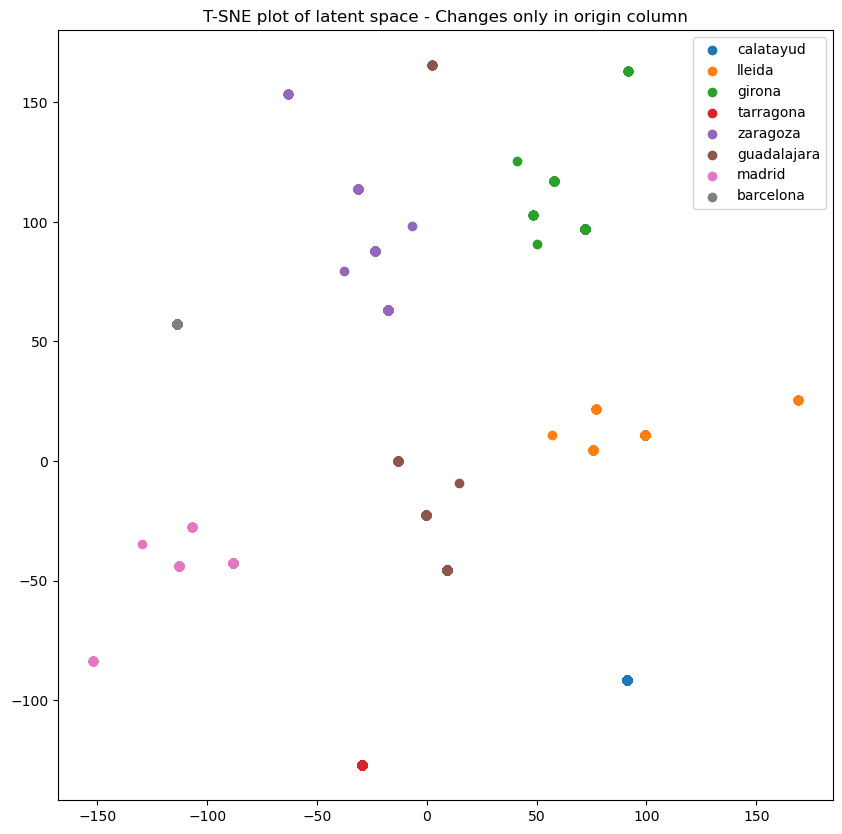

In [24]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
tsne_latent_space = tsne.fit_transform(latent_space)

# Scatter plot tsne_latent_space
plt.figure(figsize=(10, 10))
plt.title("T-SNE plot of latent space - Changes only in origin column")

for i, origin in enumerate(origin_values):
    print(f"Shape of tsne_latent_space[df_test['origin'] == {origin}]: {tsne_latent_space[df_test['origin'] == origin].shape}")
    plt.scatter(tsne_latent_space[df_test['origin'] == origin, 0],
                tsne_latent_space[df_test['origin'] == origin, 1],
                label=origin)
plt.legend()
plt.show()

94/94 [==============================] - 0s 977us/step


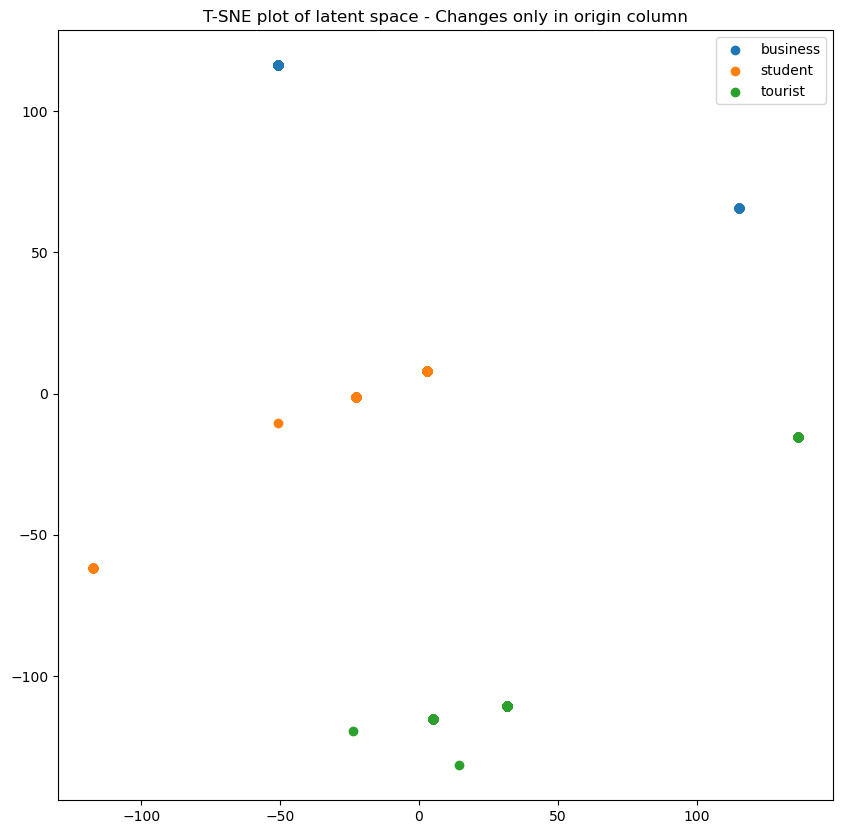

In [28]:
# Get latent space from every possible combination of fixed dfs
df_test = test_embedding.df.copy()

# Get set of values in 'origin' column
origin_values = set(df_test['origin'].values)
destination_values = set(df_test['destination'].values)
user_pattern_values = set(df_test['user_pattern'].values)
week_day_values = set(df_test['week_day'].values)
month_values = set(df_test['month'].values)
time_values = set(df_test['time'].values)

df_test = test_embedding.df.copy()
df_test['origin'] = 'madrid'
df_test['destination'] = 'barcelona'
df_test['week_day'] = 'monday'
df_test['month'] = 'january'
df_test['time'] = datetime.datetime(year=2023, month=1, day=1, hour=18, minute=30)

fixed_data = AutoencoderEmbedding(df = df_test, embedding_dim=EMBEDDING_DIM)

latent_space = encoder_model.predict(x = [fixed_data.words_embeddings, fixed_data.time_embedding])

tsne = TSNE(n_components=2, random_state=0)
tsne_latent_space = tsne.fit_transform(latent_space)

# Scatter plot tsne_latent_space with legend of origin
plt.figure(figsize=(10, 10))
plt.title("T-SNE plot of latent space - Changes only in origin column")

for i, user_pattern in enumerate(user_pattern_values):
    plt.scatter(tsne_latent_space[df_test['user_pattern'] == user_pattern, 0],
                tsne_latent_space[df_test['user_pattern'] == user_pattern, 1],
                label=user_pattern)
plt.legend()
plt.show()

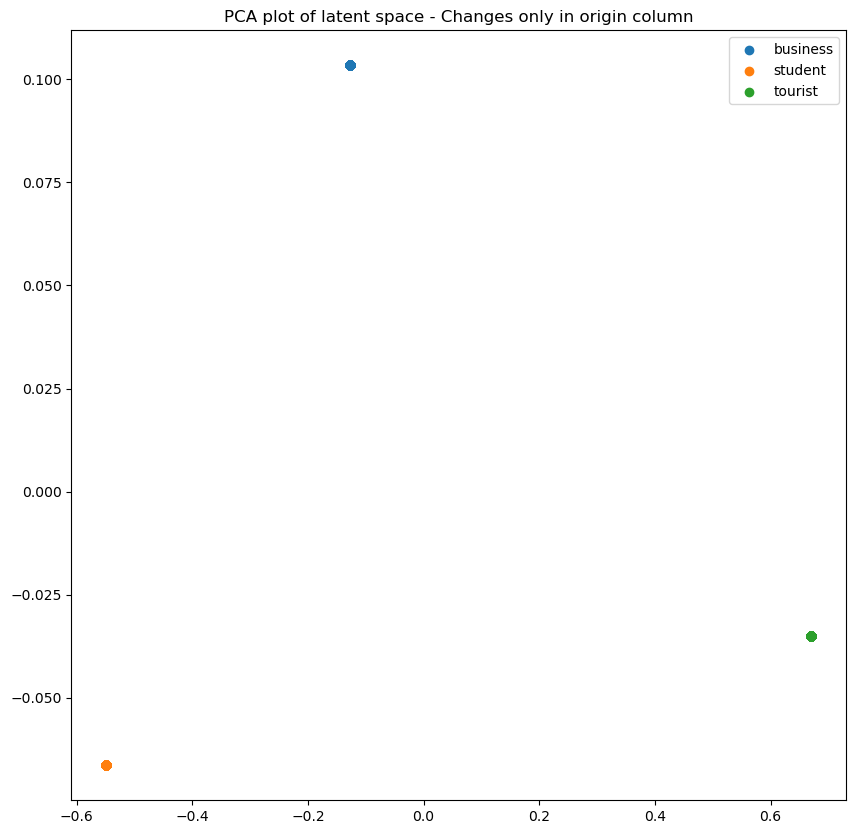

In [35]:
# PCA on latent space to analyze relationship between latent factors and input variables
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_latent_space = pca.fit_transform(latent_space)

# Scatter plot pca_latent_space with legend of origin
plt.figure(figsize=(10, 10))
plt.title("PCA plot of latent space - Changes only in origin column")

for i, user_pattern in enumerate(user_pattern_values):
    plt.scatter(pca_latent_space[df_test['user_pattern'] == user_pattern, 0],
                pca_latent_space[df_test['user_pattern'] == user_pattern, 1],
                label=user_pattern)

plt.legend()
plt.show()

In [51]:
import numpy as np
import pandas as pd

from scipy.stats import pearsonr, spearmanr

# Calculate Pearson correlation
pearson_corr = []
p_values_pearson = []
for i in range(5):
    correlation, p_value = pearsonr(latent_space[:, i], test_embedding.df_embedding['time'])
    pearson_corr.append(correlation)
    p_values_pearson.append(p_value)

# Calculate Spearman correlation
spearman_corr = []
p_values_spearman = []
for i in range(5):
    correlation, p_value = spearmanr(latent_space[:, i], test_embedding.df_embedding['time'])
    spearman_corr.append(correlation)
    p_values_spearman.append(p_value)

# Create dataframe with results
resultados_correlacion = pd.DataFrame({'Latent factor': range(1, 6),
                                      'Pearson correlation': pearson_corr,
                                      'Pearson p-value': p_values_pearson,
                                      'Spearman correlation': spearman_corr,
                                      'Spearman p-valus': p_values_spearman})

# Print results
print(resultados_correlacion)

   Latent factor  Pearson correlation  Pearson p-value  Spearman correlation  \
0              1             0.263315     9.176944e-49              0.271803   
1              2            -0.332068     3.801670e-78             -0.326546   
2              3             0.822054     0.000000e+00              0.825664   
3              4            -0.162147     4.010516e-19             -0.211377   
4              5             0.430810    7.530785e-136              0.419955   

   Spearman p-valus  
0      5.806504e-52  
1      1.748882e-75  
2      0.000000e+00  
3      1.198065e-31  
4     1.691649e-128  
